## Equações de Bellman dos jogadores para o modelo de Dou et al (2019)

In [2]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba as nb
from numba import jit, njit, jitclass, prange, float64, int32
%matplotlib inline


import time

### Parâmetros do jogo

In [34]:
μ = 4.566 #número de meses entre períodos, traduz a quantidade de períodos t em quantidade de meses
# ρ = 0.884 # (1 - ρ) é a taxa de depreciação da empresa a cada período
ρ = 0.5 #testando nova taxa de depreciação
β = 9.84 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.044 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte


hs0 = 0.28 #habilidade inicial de s
hj0 = 0.36 #habilidade inicial de j

λj = 0.346



Valores que virão dos dados

In [35]:
Vmax = float64(1.0) #valor máximo de reorganização da firma
L = float64(0.25) #valor inicial de liquidação da firma
Ds = float64(0.28) #valor da dívida com credor sênior
Dj = float64(0.35) #valor da dívida com credor júnior

D = Ds + Dj #valor total da dívida, usada para escalar custos, por exemplo


Definições iniciais: custo, valores de liquidação, valor máximo de reorganização da firma a cada período, número de rounds

In [36]:
#função custo
def Ct(t):
    if(t == 0):
        return 0
    else:
        return c0 * D + c1 * t * D
    
#test
Ct(0)    
Ct(1)


0

0.037169999999999995

In [37]:
#number of periods
def max_turns(Vmax, L, ρ):
    t = 0
    
    while(ρ**(t-1) * Vmax - Ct(t) > L - Ct(t)):
        t += 1
    return t
#     T = (np.log(L) - np.log(Vmax))/np.log(ρ) + 1
    
#     return int32(T)

T = max_turns(Vmax, L, ρ)
T


#array com custos em cada período
C = np.empty(T)

for t in range(T):
    C[t] = Ct(t)

3

In [38]:
#value of the firm in each period

def Vt(Vmax, Tmax, ρ):
    
    V = np.empty(Tmax)
    
    V[0] = Vmax
    
    for t in range(1, Tmax):
        V[t] = Vmax * ρ**(t-1) - Ct(t)
        
    return V

V = Vt(Vmax, T, ρ)
V
    
        
        
    

array([1.     , 0.96283, 0.45338])

In [39]:
#valores de liquidação

def s_L(t):
    
    return np.minimum(L - Ct(t), Ds)

s_L(1)

def j_L(t):
    
    return np.minimum(L - Ct(t) - s_L(t), Dj)
    
j_L(0)

0.21283000000000002

0.0

Habilidades possíveis dos jogadores e funções de massa de probabilidade

In [40]:
#grid size
grid = 100

hlow = 0.01
hhigh = 1.0

#começa no menor valor possível, vai até o maior valor possível num intervalo do tamanho do grid
hvals = np.linspace(hlow, hhigh, grid)

hvals
hvals[6]


array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

0.06999999999999999

Testando se o python consegue criar 2 x 10 arrays para os valores de continuação:
* 2 porque temos s e j
* 10 porque seria a quantidade de clusters

Se não conseguir, precisaremos pensar numa maneira de economizar memória no futuro

In [41]:
#test
test_W = np.zeros((2, 10, T, grid, grid, grid))

In [42]:
test_W.shape

(2, 10, 3, 100, 100, 100)

In [43]:
def cdf(x, lt):
    
    #return the cdf of x given the lower bound lt
    #geq than 1 because of our discretization method 
    if(x >=1):
        
        return 1
    
    else:
        
        if(x >= lt):
            return 1 - ((1-x)**β)/((1-lt)**β)
        else:
            return 0
        
#test      
cdf(0.5, 1)
cdf(0.5, 0.4)
            
cdf(0.99, 0.01)

cdf(1, 0.01)

cdf(1, 0.9)

0

0.8337136736331454

1.0

1

1

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.41624601e-02, 1.64810825e-01, 1.37355767e-01,
       1.14036220e-01, 9.42978761e-02, 7.76511534e-02, 6.36648020e-02,
      

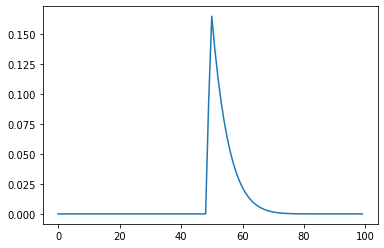

In [46]:
#nova versão da função pmf: agora cada ponto do grid é o centro da cdf
def pmf_cdf(lt, δ = hlow/2):
    
    pmf = np.empty(grid)
    
    
    for i, h in enumerate(hvals):
        pmf[i] = cdf(h+δ, lt) - cdf(h-δ, lt)
        
    return pmf


lt = 0.5
pmf_cdf(lt)
plt.plot(pmf_cdf(lt))

In [47]:
#gerando as pmfs

#probability mass function
pmf = np.empty((grid,grid))


for t, θt in enumerate(hvals):
    pmf[t,:] = pmf_cdf(θt)
    
#precisamos de uma pmf para quando temos lkt e queremos saber θk,t+1
#chamaremos de pmf2
pmf2 = np.empty((grid, grid))

for i in range(len(hvals)):
    for j in range(len(hvals)):
        pmf2[i, j] = np.sum(pmf[i, :] * pmf[:, j])


Arrays dos valores de continuação dos jogadores

In [48]:
#continuation values
#period, θkt, ℓkt, ℓmt
s_W = np.zeros((T, grid, grid, grid))
j_W = np.copy(s_W)


#optimal payments
#period, θkt, ℓmt, outputs
Pst_array = np.zeros((T, grid, grid, 6))
Pjt_array = np.copy(Pst_array)

In [49]:
#populating the last period with the liquidation values
s_W[(T-1), ...] = s_L(T)
j_W[(T-1), ...] = j_L(T)

Funções para calcular os valores de continuação dos jogadores

In [50]:
#função para mapear os valores das habilidades aos arrays
@njit
def find(h):
    
    return np.searchsorted(hvals, h)

find(hvals[7])
type(find(hvals[7]))

find(hvals)

#checando se temos valores repetidos
count = np.bincount(find(hvals))
np.where(count > 1)

7

int

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

(array([], dtype=int64),)

In [51]:
#cdf for the discretized distribution

def cdf_discrete(x, lt):
    #returns the probability that θt takes a value less than x, given lt
    #we use strictly less than x because now it is a discrete distribution
    return np.sum(pmf[find(lt), :find(x)])


#test
cdf(0.5, 0.01)
cdf_discrete(0.5, 0.01)

0.998795478578984

0.998671575594218

In [52]:
#array to tell us the size of the pie on next period
#arguments: (period, θk,t+1)
U = np.zeros((T, grid))

U = (hvals[:,None] * V[None,:] - C).T


#test
U[1,0] == hvals[0] * V[1] - Ct(1)


U[2,5] == hvals[5] * V[2] - Ct(2)

True

True

In [53]:
#função cutoff

@njit
def cutoff_m(t, Pkt, hkt, lmt, m_W):
    
    cmt = find(lmt)
    
    while(Pkt > m_W[t, cmt, cmt, find(hkt)] and hvals[cmt] < hhigh):
        cmt += 1
            
    
    #returns the index of the cutoff
    return max(int32(cmt), find(lmt))


cutoff_m(T-1, 0.01, 0.5, 0.4, j_W)

99

In [54]:
#function to select the correct pmf function given the cutoff


def h_m(cutoff_m, lmt):
    #takes the indexes of cutoff and lmt
    #if cutoff > lmt, pmf[cutoff]
    #otherwise, pmf2[lmt]
    
    if(cutoff_m > lmt):
        return pmf[cutoff_m, lmt:] #'lmt:' is to make sure the dimensions are ok
    
    else:
        return pmf2[lmt, lmt:]
    

#test
h_m(49,50) == pmf2[50, 50:]
h_m(99, 50) == pmf[99, 50:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [55]:
#função payoff ótimo

#retorna a política ótima também
#possible shares of the pie
share = np.arange(0, 1.0, step = 0.01)

#falta checar de novo as dimensões
def Pkt(t, hkt, lmt, k_W, m_W, k_L):
    
    #grid of payments is the possible continuation values of the opponent
#     Pkt_grid = m_W[t, find(lmt):, find(lmt), find(hkt)]

    #new grid of payments is the share of the pie tomorrow based on the hability today
    Pkt_grid = np.empty(share.size + 1)
    
    #the first possible value is -Vmax, which is an offer so low that will be rejected for sure (waiting offer)
    Pkt_grid[0] = -Vmax
    
    #the other values are the shares of the pie
    Pkt_grid[1:] = share * U[t, find(hkt)]
    
    
    cutoffs = int32(np.empty(Pkt_grid.shape))
    
    #loop for calculating the cutoffs
    for i, Pkt in enumerate(Pkt_grid):
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    
#     breakpoint()

    #cálculo de E1####
    
    #pE1[3,6] is the third possible payment combined with the sixth hability above hkt

    pE1 = np.array(U[t, None, find(hkt):] - Pkt_grid[:, None])
    
    
    #array com as probabilidades
    #probabiilidades de k amanhã dado a habilidade verdadeira hoje
    probk = pmf[find(hkt),find(hkt):]

    #probabilidade de m amanhã, dado o lower bound hoje
    probm = pmf2[find(lmt), find(lmt):]

    #tipo de produto de kronecker do wikipedia
    #exemplo didático
    # c = np.array([[1], [2]])
    # d = np.array([[1,2], [3,4]])

    # c
    # d

    # np.outer(c,d)

    prob = np.outer(probk,probm)
    
    #multiplicando pE1 pelo array de probabilidades
    pE1 = np.dot(pE1, prob)

    #array indicador
    IE1 = np.where(m_W[t, find(lmt):, cutoffs, find(hkt)] <= Pkt_grid[:,None] , 1, 0)

    #payoff de E1
    E1 = np.multiply(pE1, IE1)
    
    #soma ao longo das colunas (axis = 1) para que cada linha tenha o payoff esperado de propor um pagamento aceitável
    E1 = np.sum(E1, axis = 1)
    
    
    # #cálculo de E2####

    pE2 = k_W[t, find(hkt):, find(hkt), cutoffs]
    
    #multiplicando pE2 pelo array de probabilidades
    pE2 = np.dot(pE2, prob)
    
    #array indicador de 
    IE2 = np.where(IE1 == 1, 0, 1)

    
    #payoff
    E2 = np.multiply(pE2, IE2)
    E2 = np.sum(E2, axis = 1)

    #matriz dos payoffs####
    matrix_payoff = E1 + E2

    payoff_reorg = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pkt_grid[index]
    
    
    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)
    
    
    
    #waiting payoff is associated with the first possible payment, which is -Vmax, the waiting offer
    payoff_wait = matrix_payoff[0]
    
    
    
#     #avoiding numerical precision issues when comparing payoffs
#     if(np.allclose(payoff_wait, payoff_reorg, atol = 1e-15)):
#         #if the difference between waiting and reorganization payoff is small, then we use waiting payoff
#         payoff_max = np.max((payoff_liq, payoff_liq, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_liq, payoff_reorg))
#     else:
#         payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))

    
    
    payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
    policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))
                         
    #retorna o payoff de esperar também para facilitar a verificação do código
    return pagamento, cutoffs[index], payoff_reorg, payoff_wait, payoff_max, policy
        

t, hkt, lmt, k_W, m_W, k_L = T-1, 0.5, 0.6, s_W, j_W, s_L
# share * U[t, find(hkt)]

Pkt(t, hkt, lmt, k_W, m_W, k_L)



(0.0, 59, 0.2009452145111205, 0.19393000000000019, 0.20338, 0)

In [56]:
#função payoff ótimo

#retorna a política ótima também
#possible shares of the pie
share = np.arange(0, 1.0, step = 0.01)

#Pkt2
def Pkt(t, hkt, lmt, k_W, m_W, k_L):
    
    #grid of payments is the possible continuation values of the opponent
#     Pkt_grid = m_W[t, find(lmt):, find(lmt), find(hkt)]

    

    #new grid of payments is the share of the pie tomorrow based on the hability today
    Pkt_grid = np.empty(hvals[find(lmt):].size + 1)
    
    #the first possible value is -Vmax, which is an offer so low that will be rejected for sure (waiting offer)
    Pkt_grid[0] = -Vmax
    
    #the other values are the continuation values of opponent
    Pkt_grid[1:] = m_W[t, find(lmt):, find(lmt), find(hkt)]
    
    
    cutoffs = int32(np.empty(Pkt_grid.shape))
    
    #loop for calculating the cutoffs
    for i, Pkt in enumerate(Pkt_grid):
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    
#     breakpoint()

    #cálculo de E1####
    
    #pE1[3,6] is the third possible payment combined with the sixth hability above hkt

    pE1 = np.array(U[t, None, find(hkt):] - Pkt_grid[:, None])
    
    
    #array com as probabilidades
    #probabiilidades de k amanhã dado a habilidade verdadeira hoje
    probk = pmf[find(hkt),find(hkt):]

    #probabilidade de m amanhã, dado o lower bound hoje ou o cutoff hoje
    
#     #shape is Pkt x M
#     probm = np.empty((Pkt_grid.size, hvals[find(lmt):].size))

#     for i in range(Pkt_grid.size):
#         probm[i] = h_m(cutoffs[i], find(lmt))

    
    
#     #multiplicando pE1 pelas probabilides das habilidades de k
#     pE1 = np.multiply(pE1, probk.T)
#     pE1 = np.sum(pE1, axis = 1)
    
#     #multiplicando agora pelas probabilidades das habilidades de m, dado cada Pkt
#     pE1 = np.multiply(pE1[:, None], probm)



    #ponderação pelas probabilidades
    probk = pmf[find(hkt), find(hkt):]
    probm = pmf[find(lmt), find(lmt):]
    
    prob = np.outer(probk, probm)
    
    pE1 = np.dot(pE1, prob)
    
    #array indicador
    IE1 = np.where(m_W[t, find(lmt):, cutoffs, find(hkt)] <= Pkt_grid[:,None] , 1, 0)
    
    
#     breakpoint()

    #payoff de E1
    E1 = np.multiply(pE1, IE1)
    
    #soma ao longo das colunas (axis = 1) para que cada linha tenha o payoff esperado de propor um pagamento aceitável
    E1 = np.sum(E1, axis = 1)
    
    
    # #cálculo de E2####

    pE2 = k_W[t, find(hkt):, find(hkt), cutoffs]
    
    #multiplicando pE2 pelo array de probabilidades
    pE2 = np.dot(pE2, prob)
    
    #multiplicando pelas probabilides das habilidades de k
#     pE2 = np.multiply(pE2, probk.T)
#     pE2 = np.sum(pE2, axis = 1)
    
#     #multiplicando agora pelas probabilidades das habilidades de m, dado cada Pkt
#     pE2 = np.multiply(pE2[:, None], probm)
    
    
    
    #array indicador de 
    IE2 = np.where(IE1 == 1, 0, 1)

    
    #payoff
    E2 = np.multiply(pE2, IE2)
    E2 = np.sum(E2, axis = 1)

    #matriz dos payoffs####
    matrix_payoff = E1 + E2

    payoff_reorg = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pkt_grid[index]
    
    
    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)
    
    
    
    #waiting payoff is associated with the first possible payment, which is -Vmax, the waiting offer
    payoff_wait = matrix_payoff[0]
    
    
    
#     #avoiding numerical precision issues when comparing payoffs
#     if(np.allclose(payoff_wait, payoff_reorg, atol = 1e-15)):
#         #if the difference between waiting and reorganization payoff is small, then we use waiting payoff
#         payoff_max = np.max((payoff_liq, payoff_liq, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_liq, payoff_reorg))
#     else:
#         payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))

    
    
    payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
    policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))
                         
    #retorna o payoff de esperar também para facilitar a verificação do código
    return pagamento, cutoffs[index], payoff_reorg, payoff_wait, payoff_max, policy
        

t, hkt, lmt, k_W, m_W, k_L = T-1, 0.5, 0.6, s_W, j_W, s_L
# share * U[t, find(hkt)]

Pkt(t, hkt, lmt, k_W, m_W, k_L)



(0.0, 59, 0.2009452145111204, 0.1939300000000001, 0.20338, 0)

In [57]:
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)


def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

In [58]:
#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [59]:
#checando se populou ok
t, h, l = T-1, 0.5, 0.5
Pst_array[t, find(h), find(l),:] == Pst(t, h, l)

array([ True,  True,  True,  True,  True,  True])

In [60]:
#função da proposta ótima


def propose(t, hkt, lkt, lmt, Pkt_array):
    #apenas busca o valor de Pkt
    
    payoff_max, policy = Pkt_array[t, find(hkt), find(lmt)][-2:]
    
    return payoff_max, policy

#test


t, hkt, lkt, lmt, Pkt_array = T-1, 0.5, 0.01, 0.5, Pst_array

Pst_array[t, find(hkt), find(lmt), :] = Pkt(t, hkt, lmt, k_W, m_W, k_L)

propose(t, hkt, lkt, lmt, Pkt_array)


(0.20338, 0.0)

In [61]:
#função de threshold

def threshold_m(t, lkt, lmt, Pmt_array):
    
    #procura onde a última entrada é diferente de 0 (policy de liquidar a firma)
    threshold_vector = np.array(np.where(Pmt_array[t, :, find(lkt), -1] != 0.0))
    
    if(threshold_vector.size == 0):
        #threshold does not exist
        ts = hhigh #will update lower bound to 1 just to accelerate the calculations
        probm_liq = 1.0
        
    else:
        ts = hvals[np.min(threshold_vector)]
    
        #probability that m will propose liquidation next period
        if(lmt >= ts):
            probm_liq = 0.0
        else:
            probm_liq = cdf_discrete(ts,lmt)
        
    #returns the reorganization threshold and the probability that m will propose liquidation in t
    return ts, probm_liq
    
    
 
t, lkt,lmt, Pmt_array = T-1, 0.5,0.51, Pst_array

Pmt_array[t, :, find(lkt), -1]

threshold_m(t, lkt,lmt,  Pmt_array)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

(0.51, 0.0)

In [62]:
#payoff esperado de responder a uma proposta de reorganização

def respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W):
    ts, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
    
    lmt = max(ts, lmt)
    
    
    #the possible values of payment given by the opponent
    Pmt_grid = Pmt_array[t, find(lmt):, find(lkt), 0]
    cutoffs = Pmt_array[t, find(lmt):, find(lkt), 1]
    cutoffs = int32(cutoffs)


    #A1### 
    
    #payoff quando receber pagamento é melhor respota
    pA1 = Pmt_grid

    #ponderação pelas probabilidades
    probk = pmf[find(hkt), find(hkt):]
    probm = pmf[find(lmt), find(lmt):]


    #primeiro vamos ver a função indicadora
    IA1 = np.where(k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T <= Pmt_grid, 1, 0)

    #IA1 tem S linhas e J colunas

    #queremos uma matriz de probabiidades com a mesma dimensão
    prob = np.outer(probk, probm)

    pA1 = np.multiply(pA1.T, prob)

    A1 = np.multiply(pA1, IA1)

    #A2####

    IA2 = np.where(IA1 == 1, 0, 1)

    pA2 = k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T

    pA2 = np.multiply(pA2, prob)

    A2 = np.multiply(pA2, IA2)

    payoff = A1 + A2
    payoff = np.sum(payoff)

    #returns the expected value of answering a reorganization proposal and the probability of liquidation
    return payoff * (1.0 -probm_liq), probm_liq

#test1
t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pjt_array, s_W
respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)


lmt, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
Pjt(t, lmt, lkt)


#test2
t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pst_array, j_W
respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)

Pst(t, lmt, lkt)


(0.1939300000000002, 0.0)

(0.19393, 49, 0.0029003889749073778, 0.0, 0.0029003889749073778, 2)

(0.0, 0.09416246009695162)

(0.0, 49, 0.20094521451112046, 0.19393000000000019, 0.20338, 0)

In [63]:
ts, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
    
lmt = max(ts, lmt)


#the possible values of payment given by the opponent
Pmt_grid = Pmt_array[t, find(lmt):, find(lkt), 0]
cutoffs = Pmt_array[t, find(lmt):, find(lkt), 1]
cutoffs = int32(cutoffs)


#A1### 

#payoff quando receber pagamento é melhor respota
pA1 = Pmt_grid

#ponderação pelas probabilidades
probk = pmf[find(hkt), find(hkt):]
probm = pmf[find(lmt), find(lmt):]


#primeiro vamos ver a função indicadora
IA1 = np.where(k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T <= Pmt_grid, 1, 0)

#IA1 tem S linhas e J colunas

#queremos uma matriz de probabiidades com a mesma dimensão
prob = np.outer(probk, probm)

In [64]:
prob.shape

probk.shape

IA1.shape
pA1.shape

(51, 50)

(51,)

(51, 50)

(50,)

In [65]:
#payoff esperado de responder a uma proposta de liquidação

def respond_liq(t, hkt, lkt, lmt, k_L, m_L):
    
    #reorganiza pagando o valor de liquidação do oponente
    payoff_reorg = np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))
    
    payoff_liq = k_L(t)
    
    return max(payoff_liq, payoff_reorg)

t, hkt, lkt, lmt, k_L, m_L = T-1, 0.5, 0.5, 0.5, s_L, j_L

respond_liq(t, hkt, lkt, lmt, k_L, m_L)
np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))
k_L(t)

0.20338

0.20094521451112035

0.20338

In [66]:
#payoff esperado de responder
def respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L):
    
    payoff_rreorg, probm_liq = respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)
    
    return payoff_rreorg + probm_liq * respond_liq(t, hkt, lkt, lmt, k_L, m_L)
    
t, hkt, lkt, lmt, k_L, m_L, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, s_L, j_L, Pst_array, j_W

respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L)


0.01915076113451802

In [67]:
#funções de s baseado nas funções genéricas
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)

def s_propose(t, θst, ℓst, ℓjt):
    return propose(t, θst, ℓst, ℓjt, Pst_array)

def threshold_j(t, ℓst, ℓjt):
    return threshold_m(t, ℓst, ℓjt, Pjt_array)

def s_respond_reorg(t, θst, ℓst, ℓjt):
    return respond_reorg(t, θst, ℓst, ℓjt, Pjt_array, s_W)

def s_respond_liq(t, θst, ℓst, ℓjt):
    return respond_liq(t, θst, ℓst, ℓjt, s_L, j_L)
    
def s_respond(t, θst, ℓst, ℓjt):
    return respond(t, θst, ℓst, ℓjt, Pjt_array, s_W, s_L, j_L)


In [68]:
#funções de j baseado nas funções genéricas
def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

def j_propose(t, θjt, ℓjt, ℓst):
    return propose(t, θjt, ℓjt, ℓst, Pjt_array)

def threshold_s(t, ℓjt, ℓst):
    return threshold_m(t, ℓjt, ℓst, Pst_array)

def j_respond_reorg(t, θjt, ℓjt, ℓst):
    return respond_reorg(t, θjt, ℓjt, ℓst, Pst_array, j_W)

def j_respond_liq(t, θjt, ℓjt, ℓst):
    return respond_liq(t, θjt, ℓjt, ℓst, j_L, s_L)
    
def j_respond(t, θjt, ℓjt, ℓst):
    return respond(t, θjt, ℓjt, ℓst, Pst_array, j_W, j_L, s_L)

### Populando as matrizes do jogo

##### 1,2,3 Testando

In [69]:
t = (T-1)


start = time.process_time()

#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
            

duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para popular o período 2 : 10.96875


In [70]:
#testando funções
t, hkt, lkt, lmt = T-1, 0.6, 0.4, 0.5



In [71]:
s_propose(t, hkt, lkt, lmt)


threshold_j(t, ℓkt, ℓmt)
np.where(Pjt_array[t, :, find(lkt), -1] == 2)
#ok
print('respond_reorg')
s_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
s_respond_liq(t, hkt, lkt, lmt)
s_L(t)


#ok
s_respond(t, hkt, lkt, lmt)


#teste

s_respond(t, hkt, lkt, lmt) == s_respond_reorg(t, hkt, lkt, lmt)[0] + s_respond_reorg(t, hkt, lkt, lmt)[1] * s_respond_liq(t, hkt, lkt, lmt)

(0.24209147652152113, 2.0)

(0.49, 0.0)

(array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
        99], dtype=int64),)

respond_reorg


(0.19393000000000013, 0.0)

0.24209147652152102

0.20338

0.19393000000000013

True

In [72]:
j_propose(t, hkt, lkt, lmt)


#o threshold de ambos é para dar igual mesmo?
threshold_s(t, ℓkt, ℓmt)
np.where(Pst_array[t, :, find(lkt), -1] == 2)
#ok
print('respond_reorg')
j_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
j_respond_liq(t, hkt, lkt, lmt)
j_L(t)


#ok
j_respond(t, hkt, lkt, lmt)

#teste

j_respond(t, hkt, lkt, lmt) == j_respond_reorg(t, hkt, lkt, lmt)[0] + j_respond_reorg(t, hkt, lkt, lmt)[1] * j_respond_liq(t, hkt, lkt, lmt)

(0.048161476521521036, 2.0)

(0.51, 0.09416246009695162)

(array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int64),)

respond_reorg


(0.0, 0.09416246009695162)

0.03871147652152099

0.0

0.0036451678632517994

True

#### Populando todos os períodos

In [73]:


for t in range(T-1, 0, -1):

    start = time.process_time()

    #populando as matrizes para continuar os testes

    for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
    print("tempo total para preparar o terreno do período", t, ":", time.process_time() - start)
    
    
    
    for i, hk in enumerate(hvals):
        for j, lk in enumerate(hvals):
            for k, lm in enumerate(hvals):
                s_W[(t-1), i, j, k] = λj * s_respond(t, hk, lk, lm) + (1-λj) * s_propose(t, hk, lk, lm)[0]
                j_W[(t-1), i, j, k] = λj * j_propose(t, hk, lk, lm)[0] + (1-λj) * j_respond(t, hk, lk, lm)


    duração = time.process_time() - start



    print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para preparar o terreno do período 2 : 10.5625
tempo total para popular o período 2 : 264.875
tempo total para preparar o terreno do período 1 : 11.0625
tempo total para popular o período 1 : 272.125


In [74]:
#preparando o terreno no período 0 
t = 0

for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [75]:
#testando funções
t, hkt, lkt, lmt = 0, 0.6, 0.4, 0.5

Pst(t, hkt, lmt)
Pjt(t, hkt, lmt)

(0.12241376344283177,
 57,
 0.5038067354204304,
 0.46628342043179544,
 0.5038067354204304,
 2)

(0.41645790795464255,
 56,
 0.20106636282568893,
 0.14882962897346008,
 0.20106636282568893,
 2)

Salvando os dados

In [76]:
import os.path
date = '22_10'

np.save(os.path.join('Ws_array_'+date), s_W)
np.save(os.path.join('Wj_array_'+date), j_W)
np.save(os.path.join('Pst_array_'+date), Pst_array)
np.save(os.path.join('Pjt_array_'+date), Pjt_array)


Carregando os dados

#dia 17_10 foi o último dia com dados errados, ρ = 0.9xxx. Antes de corrigir o threshold
#dia 19_10 foi quando consertei o threshold, ρ = 0.5

import os.path
date = '22_10'

s_W = np.load(os.path.join('Ws_array_'+date+'.npy'))
j_W = np.load(os.path.join('Wj_array_'+date+'.npy'))
Pst_array = np.load(os.path.join('Pst_array_'+date+'.npy'))
Pjt_array = np.load(os.path.join('Pjt_array_'+date+'.npy'))


### Gráfico das funções

Gráfico das funções propose e respond

In [77]:
def graf_func(θ_vector, t, creditor,  function, ℓkt, ℓmt):
    #true hability increases while lower bounds stay at 0.5
    #t is also endogenous 
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θ_vector


    #storing the function vals in t
    graf_vals = []

    for θt in θ_vector:
        function_val = function(t, θt, ℓkt, ℓmt)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
        
        
#     label_val = repr(function)
    title_val = print(function, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt)

    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")

    ax.set_title(title_val)

    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()

No handles with labels found to put in legend.


<function s_propose at 0x0000029C9AEA2F78> ℓkt =  0.5 ℓmt =  0.5


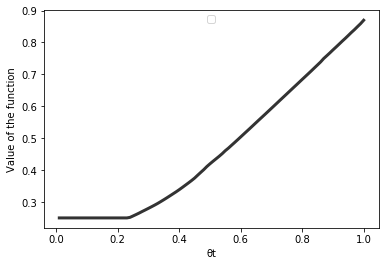

No handles with labels found to put in legend.


<function s_propose at 0x0000029C9AEA2F78> ℓkt =  0.3 ℓmt =  0.9


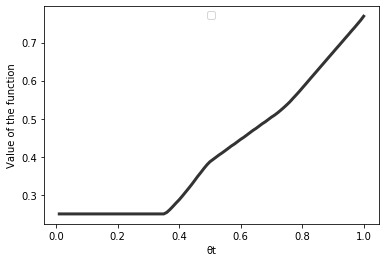

In [78]:
graf_func(hvals, 0, 's', s_propose, ℓkt = 0.5, ℓmt = 0.5)
graf_func(hvals, 0 , 's', s_propose, ℓkt = 0.3, ℓmt = 0.9)

No handles with labels found to put in legend.


<function s_respond at 0x0000029C9B0D1DC8> ℓkt =  0.5 ℓmt =  0.5


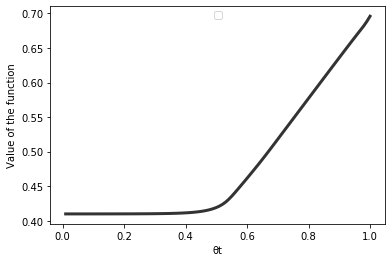

No handles with labels found to put in legend.


<function s_respond at 0x0000029C9B0D1DC8> ℓkt =  0.3 ℓmt =  0.9


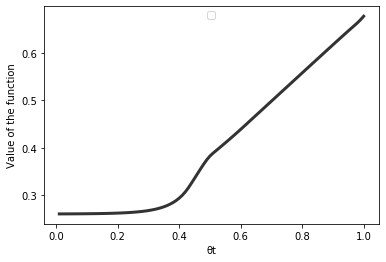

In [79]:
graf_func(hvals, 0, 's', s_respond, ℓkt = 0.5, ℓmt = 0.5)
graf_func(hvals, 0 , 's', s_respond, ℓkt = 0.3, ℓmt = 0.9)

Gráfico do valor de continuação

No handles with labels found to put in legend.


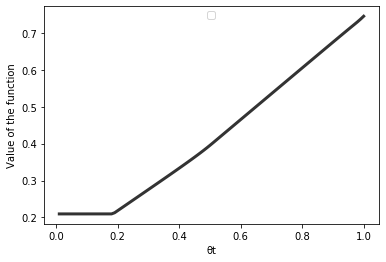

No handles with labels found to put in legend.


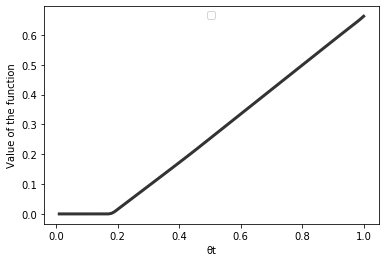

In [80]:
def graf_func_value(k_array, ℓkt, ℓmt, t):
    #t starts at t=1
    
    fig, ax = plt.subplots()

    #size of X axis
    X = hvals


    #storing the function vals in t
    graf_vals = k_array[(t-1), :, find(ℓkt), find(ℓmt)]


    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)
    
#     name = str(k_array)
#     title_val = print(name, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt, 'period = ', t)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")


    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    
graf_func_value(s_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

graf_func_value(j_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

Gráfico das propostas ótimas

In [81]:

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(hvals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(hvals):
        for j, lj in enumerate(hvals):
            graf[i,j] = function(t, θs, θs, lj)[1]


    fig, ax = plt.subplots()

    cs1 = ax.contourf(hvals, hvals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(hvals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
    plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()

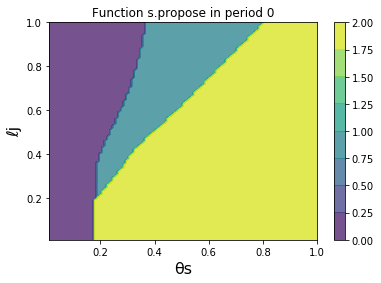

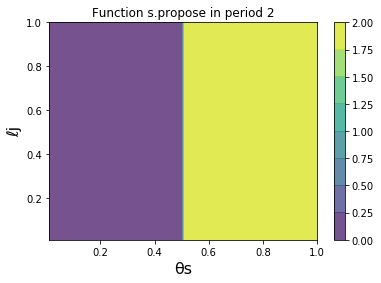

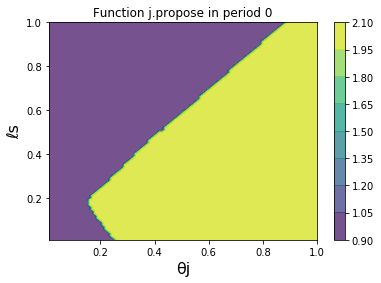

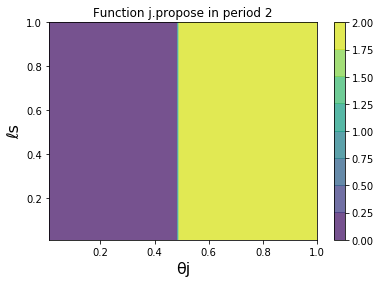

In [82]:
graf_proposal(s_propose,'s.propose', 0, 'θs', 'ℓj')

# graf_proposal(s_propose,'s.propose', 1, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal(j_propose, 'j.propose', 0, 'θj', 'ℓs')
# graf_proposal(j_propose, 'j.propose', 1, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 2, 'θj', 'ℓs')

#### Checando função propose nos locais onde ela está estranha

In [50]:
def check_proposal(t, fixed_param, fixed_val, low, high, Pkt):
    #fixed parameter = lm or hk
    
    if(fixed_param == 'hk'):
        for i in range(find(low), find(high)):
            print(Pkt(t, fixed_val, hvals[i]), i)
        
        
    else:
        for i in range(find(low), find(high)):
            print(Pkt(t, hvals[i], fixed_val ), i)
    
    
#test
check_proposal(2, 'lm', 0.8, 0.4, 0.5, Pjt)

(-1.0, 79, 0.02572087545352423, 0.02572087545352423, 0.02572087545352423, 1) 39
(-1.0, 79, 0.027053011151432268, 0.027053011151432268, 0.027053011151432268, 1) 40
(-1.0, 79, 0.02844252641420127, 0.02844252641420127, 0.02844252641420127, 1) 41
(-1.0, 79, 0.028779454517281648, 0.028779454517281648, 0.028779454517281648, 1) 42
(-1.0, 79, 0.032542133030311934, 0.032542133030311934, 0.032542133030311934, 1) 43
(-1.0, 79, 0.03266282697042728, 0.03266282697042728, 0.03266282697042728, 1) 44
(-1.0, 79, 0.03435026574125442, 0.03435026574125442, 0.03435026574125442, 1) 45
(-1.0, 79, 0.036303664276306984, 0.036303664276306984, 0.036303664276306984, 1) 46
(-1.0, 79, 0.03666060754317879, 0.03666060754317879, 0.03666060754317879, 1) 47
(-1.0, 79, 0.037475290252309536, 0.037475290252309536, 0.037475290252309536, 1) 48


1) Valores de S na espera. hk = 0.2 e lm variando de 0.2 a 0.5. Conclusão: o payoff de liquidar realmente fica mais alto a partir de um certo nível de lmt

In [51]:
hvals[20]

0.21000000000000002

In [52]:
check_proposal(0, 'hk', 0.2, 0.01, 0.5, Pst)

(-1.0, 0, 0.27143971520957416, 0.27143971520957416, 0.27143971520957416, 1) 0
(-1.0, 1, 0.2708524079128766, 0.2708524079128766, 0.2708524079128766, 1) 1
(-1.0, 2, 0.27026647204216836, 0.27026647204216836, 0.27026647204216836, 1) 2
(-1.0, 3, 0.26964825026639455, 0.26964825026639455, 0.26964825026639455, 1) 3
(-1.0, 4, 0.269012198090145, 0.269012198090145, 0.269012198090145, 1) 4
(-1.0, 5, 0.26837409994595957, 0.26837409994595957, 0.26837409994595957, 1) 5
(-1.0, 6, 0.26769279993220046, 0.26769279993220046, 0.26769279993220046, 1) 6
(-1.0, 7, 0.26699414680640415, 0.26699414680640415, 0.26699414680640415, 1) 7
(-1.0, 8, 0.26624093297977186, 0.26624093297977186, 0.26624093297977186, 1) 8
(-1.0, 9, 0.2654771790558864, 0.2654771790558864, 0.2654771790558864, 1) 9
(-1.0, 10, 0.26464886303470025, 0.26464886303470025, 0.26464886303470025, 1) 10
(-1.0, 11, 0.26382288336821524, 0.26382288336821524, 0.26382288336821524, 1) 11
(-1.0, 12, 0.26296256900610815, 0.26296256900610815, 0.26296256900610815

2) Valores de J propondo liquidar em T-1

lmt não importa, mas hk varia entre 0.4 e 0.5

Conclusão: de fato antes do threshold de j, a proposta ótima era esperar. E esperar tem o mesmo payoff de liquidar, então ele propõe liquidar logo.

Além disso, o threshold de reorg é maior para S do que para J. Faz sentido porque a outside option de S dá payoff maior que a outside option de J.

In [53]:
check_proposal(T-1, 'lm', 0.01, 0.4, 0.5, Pjt)

(-1.0, 0, 0.0, 0.0, 0.0, 0) 39
(-1.0, 0, 0.0, 0.0, 0.0, 0) 40
(-1.0, 0, 0.0, 0.0, 0.0, 0) 41
(-1.0, 0, 0.0, 0.0, 0.0, 0) 42
(-1.0, 0, 0.0, 0.0, 0.0, 0) 43
(-1.0, 0, 0.0, 0.0, 0.0, 0) 44
(-1.0, 0, 0.0, 0.0, 0.0, 0) 45
(-1.0, 0, 0.0, 0.0, 0.0, 0) 46
(-1.0, 0, 0.0, 0.0, 0.0, 0) 47
(-1.0, 0, 0.0, 0.0, 0.0, 0) 48


In [54]:
check_proposal(T-1, 'lm', 0.01, 0.4, 0.6, Pst)

(-1.0, 0, 0.09943000000000007, 0.09943000000000007, 0.10888, 0) 39
(-1.0, 0, 0.09943000000000007, 0.09943000000000007, 0.10888, 0) 40
(-1.0, 0, 0.09943000000000007, 0.09943000000000007, 0.10888, 0) 41
(-1.0, 0, 0.09943000000000012, 0.09943000000000012, 0.10888, 0) 42
(-1.0, 0, 0.09943000000000013, 0.09943000000000013, 0.10888, 0) 43
(-1.0, 0, 0.09943000000000014, 0.09943000000000014, 0.10888, 0) 44
(-1.0, 0, 0.09943000000000013, 0.09943000000000013, 0.10888, 0) 45
(-1.0, 0, 0.09943000000000021, 0.09943000000000021, 0.10888, 0) 46
(-1.0, 0, 0.09943000000000023, 0.09943000000000023, 0.10888, 0) 47
(-1.0, 0, 0.09943000000000006, 0.09943000000000006, 0.10888, 0) 48
(-1.0, 0, 0.09943000000000006, 0.09943000000000006, 0.10888, 0) 49
(-1.0, 0, 0.09943000000000007, 0.09943000000000007, 0.10888, 0) 50
(-1.0, 0, 0.09943000000000007, 0.09943000000000007, 0.10888, 0) 51
(-1.0, 0, 0.0994300000000001, 0.0994300000000001, 0.10888, 0) 52
(-1.0, 0, 0.09943000000000014, 0.09943000000000014, 0.10888, 0) 

In [55]:
#thresholds
print('threshold de J em T-1: ', hvals[48])

print('threshold de S em T-1: ', hvals[50])

threshold de J em T-1:  0.49
threshold de S em T-1:  0.51


3) Proposta de j em t=0

lm variando de 0.01 a 0.2, enquanto hk = 0.2

Quero ver porque tem aquela "barriga" no gráfico

In [56]:
check_proposal(0, 'hk', 0.2, 0.01, 0.2, Pjt)

(-1.0, 0, 0.08333315756819008, 0.08333315756819008, 0.08333315756819008, 1) 0
(-1.0, 1, 0.08324036369464055, 0.08324036369464055, 0.08324036369464055, 1) 1
(-1.0, 2, 0.08313411259474873, 0.08313411259474873, 0.08313411259474873, 1) 2
(-1.0, 3, 0.08301554839678216, 0.08301554839678216, 0.08301554839678216, 1) 3
(-1.0, 4, 0.08288766686527752, 0.08288766686527752, 0.08288766686527752, 1) 4
(-1.0, 5, 0.08275385663625676, 0.08275385663625676, 0.08275385663625676, 1) 5
(-1.0, 6, 0.08260554402185857, 0.08260554402185857, 0.08260554402185857, 1) 6
(-1.0, 7, 0.08243374080774915, 0.08243374080774915, 0.08243374080774915, 1) 7
(-1.0, 8, 0.08224448436672259, 0.08224448436672259, 0.08224448436672259, 1) 8
(-1.0, 9, 0.08203611568976037, 0.08203611568976037, 0.08203611568976037, 1) 9
(-1.0, 10, 0.08180433044864346, 0.08180433044864346, 0.08180433044864346, 1) 10
(-1.0, 11, 0.08154889066803207, 0.08154889066803207, 0.08154889066803207, 1) 11
(-1.0, 12, 0.0812628790015057, 0.0812628790015057, 0.0812628

Suspeita é que o grid de pagamentos não esteja fino o suficiente...

In [57]:
s_W[0, :, 8, find(0.2)]

array([0.20940892, 0.20950113, 0.20960337, 0.20971684, 0.20984291,
       0.20998313, 0.21013927, 0.21031333, 0.21050759, 0.2107245 ,
       0.21096679, 0.21123778, 0.21154122, 0.21188144, 0.21299158,
       0.21448691, 0.21616458, 0.2180514 , 0.22016951, 0.22255041,
       0.22524779, 0.22825742, 0.23155058, 0.2351385 , 0.23918252,
       0.24349662, 0.24805265, 0.25281639, 0.25789655, 0.2633375 ,
       0.26951748, 0.27596348, 0.28267682, 0.28878303, 0.29582175,
       0.30308925, 0.31047224, 0.31714698, 0.32438753, 0.33225849,
       0.34006772, 0.34760515, 0.35527733, 0.36260417, 0.37074162,
       0.37879242, 0.38595141, 0.39336344, 0.4022138 , 0.4104908 ,
       0.41859633, 0.42603817, 0.43369365, 0.44267062, 0.45096585,
       0.45827463, 0.46653249, 0.47509614, 0.48350293, 0.49141133,
       0.50000049, 0.50769567, 0.51605842, 0.52533843, 0.53263135,
       0.54109422, 0.54845355, 0.55652392, 0.56462649, 0.57328484,
       0.58183722, 0.5896782 , 0.59885821, 0.60731812, 0.61595

Anotações anteriores

In [58]:
#hk fixa e lm variando
t = 0
lm = 0.01
hk = 0.61

for i in range(find(0.01), find(0.3)):
    (Pst(t, hk, hvals[i])[2] - Pst(t, hk, hvals[i])[3])/Pst(t, hk, hvals[i])[3], Pst(t, hk, hvals[i] )[-1], i

(0.09170345675865715, 2, 0)

(0.09130099837858781, 2, 1)

(0.09180478102370138, 2, 2)

(0.09191252841857774, 2, 3)

(0.09189589445163597, 2, 4)

(0.09136947118918487, 2, 5)

(0.09108046327080414, 2, 6)

(0.090503344640463, 2, 7)

(0.08845048005494492, 2, 8)

(0.08721809849040581, 2, 9)

(0.08891321011282885, 2, 10)

(0.08804171855155808, 2, 11)

(0.08593009549721739, 2, 12)

(0.08746831507690044, 2, 13)

(0.08504011157433028, 2, 14)

(0.08398778558630526, 2, 15)

(0.08203668660452096, 2, 16)

(0.08445639531268287, 2, 17)

(0.08338369787424607, 2, 18)

(0.08331245641520231, 2, 19)

(0.08264224089032425, 2, 20)

(0.08362615261780433, 2, 21)

(0.08358794348712745, 2, 22)

(0.08438434953321604, 2, 23)

(0.08449468735398762, 2, 24)

(0.08612624962080018, 2, 25)

(0.0854652672838063, 2, 26)

(0.08462375540034588, 2, 27)

(0.08675451057733322, 2, 28)

2) Quando lm está fixo e hk varia

In [59]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.2
high = 0.5

for i in range(find(low), find(high)):
    Pst(t, hvals[i], lm )[2] - Pst(t, hvals[i], lm )[3], Pst(0, hvals[i], lm )[-1], i

(0.0, 0, 19)

(0.0, 0, 20)

(0.0, 0, 21)

(0.0, 0, 22)

(0.0, 0, 23)

(0.0, 0, 24)

(0.0, 0, 25)

(0.0, 0, 26)

(0.0, 0, 27)

(0.0, 0, 28)

(0.0, 0, 29)

(0.0, 0, 30)

(0.0, 0, 31)

(0.0, 0, 32)

(0.0, 0, 33)

(0.0, 0, 34)

(0.0, 0, 35)

(0.0, 0, 36)

(0.0, 0, 37)

(0.0, 0, 38)

(0.0, 0, 39)

(0.0, 0, 40)

(0.0, 0, 41)

(0.0, 0, 42)

(0.0, 0, 43)

(0.0, 0, 44)

(0.0, 0, 45)

(0.0, 0, 46)

(0.0, 0, 47)

(0.0, 0, 48)

In [60]:
#hk variando e lm fixa

#quero ver os cutoffs agora

t = 0
lm = 0.8
low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    i, Pst(t, hvals[i], lm )

(0, (-1.0, 79, 0.2093550781655725, 0.2093550781655725, 0.25, 0))

(1, (-1.0, 79, 0.2093733342223698, 0.2093733342223698, 0.25, 0))

(2, (-1.0, 79, 0.2093690933627917, 0.2093690933627917, 0.25, 0))

(3, (-1.0, 79, 0.20938305883108121, 0.20938305883108121, 0.25, 0))

(4, (-1.0, 79, 0.20937882354464304, 0.20937882354464304, 0.25, 0))

(5, (-1.0, 79, 0.20942775685837337, 0.20942775685837337, 0.25, 0))

(6, (-1.0, 79, 0.2094198605763644, 0.2094198605763644, 0.25, 0))

(7, (-1.0, 79, 0.20943984985024652, 0.20943984985024652, 0.25, 0))

(8, (-1.0, 79, 0.2094563749151818, 0.2094563749151818, 0.25, 0))

(9, (-1.0, 79, 0.20959516997116504, 0.20959516997116504, 0.25, 0))

(10, (-1.0, 79, 0.20969873119515622, 0.20969873119515622, 0.25, 0))

(11, (-1.0, 79, 0.20946902074696677, 0.20946902074696677, 0.25, 0))

(12, (-1.0, 79, 0.20945250525184228, 0.20945250525184228, 0.25, 0))

(13, (-1.0, 79, 0.20950662454434446, 0.20950662454434446, 0.25, 0))

(14, (-1.0, 79, 0.20963889605850067, 0.20963889605850067, 0.25, 0))

(15, (-1.0, 79, 0.20967592056469797, 0.20967592056469797, 0.25, 0))

(16, (-1.0, 79, 0.2097176564258613, 0.2097176564258613, 0.25, 0))

(17, (-1.0, 79, 0.20983104095766056, 0.20983104095766056, 0.25, 0))

(18, (-1.0, 79, 0.20988399092206245, 0.20988399092206245, 0.25, 0))

(19, (-1.0, 79, 0.2101644194040553, 0.2101644194040553, 0.25, 0))

(20, (-1.0, 79, 0.21003644097155572, 0.21003644097155572, 0.25, 0))

(21, (-1.0, 79, 0.2102294647524508, 0.2102294647524508, 0.25, 0))

(22, (-1.0, 79, 0.21038420975061137, 0.21038420975061137, 0.25, 0))

(23, (-1.0, 79, 0.21048535216887393, 0.21048535216887393, 0.25, 0))

(24, (-1.0, 79, 0.2112823819806238, 0.2112823819806238, 0.25, 0))

(25, (-1.0, 79, 0.21140815906590085, 0.21140815906590085, 0.25, 0))

(26, (-1.0, 79, 0.21110584908581256, 0.21110584908581256, 0.25, 0))

(27, (-1.0, 79, 0.21108958473636116, 0.21108958473636116, 0.25, 0))

(28, (-1.0, 79, 0.2113891326553762, 0.2113891326553762, 0.25, 0))

(29, (-1.0, 79, 0.21161167940964729, 0.21161167940964729, 0.25, 0))

(30, (-1.0, 79, 0.21193773866573595, 0.21193773866573595, 0.25, 0))

(31, (-1.0, 79, 0.2122431068314812, 0.2122431068314812, 0.25, 0))

(32, (-1.0, 79, 0.21258561873157558, 0.21258561873157558, 0.25, 0))

(33, (-1.0, 79, 0.21369191358992412, 0.21369191358992412, 0.25, 0))

(34, (-1.0, 79, 0.21436069935256696, 0.21436069935256696, 0.25, 0))

(35, (-1.0, 79, 0.2155338706920476, 0.2155338706920476, 0.25, 0))

(36, (-1.0, 79, 0.2166715129353917, 0.2166715129353917, 0.25, 0))

(37, (-1.0, 79, 0.2169558455901891, 0.2169558455901891, 0.25, 0))

(38, (-1.0, 79, 0.218745159416369, 0.218745159416369, 0.25, 0))

(39, (-1.0, 79, 0.21934565929793226, 0.21934565929793226, 0.25, 0))

(40, (-1.0, 79, 0.2206043385742293, 0.2206043385742293, 0.25, 0))

(41, (-1.0, 79, 0.2234975438472561, 0.2234975438472561, 0.25, 0))

(42, (-1.0, 79, 0.22600855821233573, 0.22600855821233573, 0.25, 0))

(43, (-1.0, 79, 0.22780674896192188, 0.22780674896192188, 0.25, 0))

(44, (-1.0, 79, 0.23001355033498813, 0.23001355033498813, 0.25, 0))

(45, (-1.0, 79, 0.23271366529292845, 0.23271366529292845, 0.25, 0))

(46, (-1.0, 79, 0.23625211176479613, 0.23625211176479613, 0.25, 0))

(47, (-1.0, 79, 0.24050546435915376, 0.24050546435915376, 0.25, 0))

(48, (-1.0, 79, 0.24674147177000486, 0.24674147177000486, 0.25, 0))

(49,
 (-1.0, 79, 0.25203273587299424, 0.25203273587299424, 0.25203273587299424, 1))

(50, (-1.0, 79, 0.2588649611249708, 0.2588649611249708, 0.2588649611249708, 1))

(51, (-1.0, 79, 0.2656069501142336, 0.2656069501142336, 0.2656069501142336, 1))

(52,
 (-1.0, 79, 0.27389992133509067, 0.27389992133509067, 0.27389992133509067, 1))

(53, (-1.0, 79, 0.2822667629962036, 0.2822667629962036, 0.2822667629962036, 1))

(54,
 (-1.0, 79, 0.29253118685906415, 0.29253118685906415, 0.29253118685906415, 1))

(55,
 (-1.0, 79, 0.30256187226843195, 0.30256187226843195, 0.30256187226843195, 1))

(56, (-1.0, 79, 0.3110250888665767, 0.3110250888665767, 0.3110250888665767, 1))

(57, (-1.0, 79, 0.3210807840685244, 0.3210807840685244, 0.3210807840685244, 1))

(58,
 (-1.0, 79, 0.33086122685906166, 0.33086122685906166, 0.33086122685906166, 1))

In [61]:
#hk variando e lm fixa
t = 0
lm = hvals[9]

low = 0.2
high = 0.5

for i in range(find(low), find(high)):
    i,Pst(t, hvals[i], lm )

(19, (-1.0, 9, 0.2654771790558864, 0.2654771790558864, 0.2654771790558864, 1))

(20,
 (-1.0, 9, 0.27022769525090196, 0.27022769525090196, 0.27022769525090196, 1))

(21,
 (-1.0, 9, 0.27521682797109864, 0.27521682797109864, 0.27521682797109864, 1))

(22, (-1.0, 9, 0.2804447518757568, 0.2804447518757568, 0.2804447518757568, 1))

(23,
 (-1.0, 9, 0.28589779648864405, 0.28589779648864405, 0.28589779648864405, 1))

(24,
 (0.027298744995704574,
  9,
  0.2915774917906685,
  0.2915629926131327,
  0.2915774917906685,
  2))

(25,
 (0.027671846578928586,
  9,
  0.29760701513624177,
  0.29744183022494075,
  0.29760701513624177,
  2))

(26,
 (0.028016509639761586,
  9,
  0.3037942260223259,
  0.30348563963096614,
  0.3037942260223259,
  2))

(27,
 (0.02830564052020486,
  9,
  0.31010224329141556,
  0.30965393477306835,
  0.31010224329141556,
  2))

(28,
 (0.028583882784285586,
  9,
  0.3165101991690876,
  0.3159271876803543,
  0.3165101991690876,
  2))

(29,
 (0.028801890044678508,
  9,
  0.3230180542085234,
  0.3223025760924862,
  0.3230180542085234,
  2))

(30,
 (0.028960935120929666,
  9,
  0.32962315365453615,
  0.32877736743882763,
  0.32962315365453615,
  2))

(31,
 (0.029113697207562413,
  9,
  0.33627914640487816,
  0.33530556726107436,
  0.33627914640487816,
  2))

(32,
 (0.034083401775802866,
  13,
  0.3435278772047142,
  0.3419166282275277,
  0.3435278772047142,
  2))

(33,
 (0.03748061543896927,
  15,
  0.3511580530063624,
  0.348607420042663,
  0.3511580530063624,
  2))

(34,
 (0.038564152391750275,
  16,
  0.35914483760554883,
  0.35533151939517776,
  0.35914483760554883,
  2))

(35,
 (0.03955845607133167,
  17,
  0.3672988700532823,
  0.3620783896360304,
  0.3672988700532823,
  2))

(36,
 (0.038025647384725934,
  16,
  0.3753776697649554,
  0.3688515215321419,
  0.3753776697649554,
  2))

(37,
 (0.04034308878977918,
  18,
  0.38248432772604257,
  0.3756928825833251,
  0.38248432772604257,
  2))

(38,
 (0.04150348806979326,
  18,
  0.391685727951376,
  0.3825901044983558,
  0.391685727951376,
  2))

(39,
 (0.04253134212954946,
  19,
  0.40030712749407327,
  0.389500652820635,
  0.40030712749407327,
  2))

(40,
 (0.045370575508991984,
  21,
  0.40860349944677016,
  0.39643790640398757,
  0.40860349944677016,
  2))

(41,
 (0.04488014239689467,
  21,
  0.4175184259536581,
  0.40341960646775255,
  0.4175184259536581,
  2))

(42,
 (0.04438036849600947,
  20,
  0.4254325674164852,
  0.41043417906462154,
  0.4254325674164852,
  2))

(43,
 (0.04516155407051523,
  21,
  0.4344545014718746,
  0.4174747663916349,
  0.4344545014718746,
  2))

(44,
 (0.04439257622986534,
  21,
  0.4436265641176592,
  0.42457128528015553,
  0.4436265641176592,
  2))

(45,
 (0.04524450795914681,
  22,
  0.45115759368310826,
  0.4316873734709192,
  0.45115759368310826,
  2))

(46,
 (0.044644108369403676,
  21,
  0.460700662552403,
  0.4387973914949547,
  0.460700662552403,
  2))

(47,
 (0.04565332787492504,
  22,
  0.4698202354318181,
  0.4459148023023515,
  0.4698202354318181,
  2))

(48,
 (0.044990802775080774,
  22,
  0.4790125218882893,
  0.45311340717297066,
  0.4790125218882893,
  2))

II) Analisado j_propose em t = 0

1) Checando quando lm = 0.01 e hk varia entre 0.2 e 0.4. 

In [62]:
#hk variando e lm fixa
t = 0
lm = 0.01

low = 0.2
high = 0.4

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], Pjt(t, hvals[i], lm )[-1], i

(0.0, 1, 19)

(0.0, 1, 20)

(0.0, 1, 21)

(0.0, 1, 22)

(0.0, 1, 23)

(0.0, 1, 24)

(0.0, 1, 25)

(0.0, 1, 26)

(0.0, 1, 27)

(0.0, 1, 28)

(0.0, 1, 29)

(2.4224258252769637e-05, 2, 30)

(9.694181199382257e-05, 2, 31)

(0.00016255676159879218, 2, 32)

(0.00021630997406368868, 2, 33)

(0.0002801396741747286, 2, 34)

(0.00032922863201972907, 2, 35)

(0.00045446735041879127, 2, 36)

(0.0011111564375195226, 2, 37)

(0.001954425702020729, 2, 38)

2) Checando quando ls = 0.8 e hk varia de 0.01 até 0.6

In [63]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    i, Pjt(t, hvals[i], lm )

(0,
 (-1.0,
  79,
  0.025502281093235924,
  0.025502281093235924,
  0.025502281093235924,
  1))

(1,
 (-1.0,
  79,
  0.025286274464795495,
  0.025286274464795495,
  0.025286274464795495,
  1))

(2,
 (-1.0,
  79,
  0.026745705395692123,
  0.026745705395692123,
  0.026745705395692123,
  1))

(3,
 (-1.0, 79, 0.02693207612797172, 0.02693207612797172, 0.02693207612797172, 1))

(4, (-1.0, 79, 0.0267344125010541, 0.0267344125010541, 0.0267344125010541, 1))

(5,
 (-1.0,
  79,
  0.026680175638010353,
  0.026680175638010353,
  0.026680175638010353,
  1))

(6,
 (-1.0, 79, 0.02912755956121599, 0.02912755956121599, 0.02912755956121599, 1))

(7,
 (-1.0, 79, 0.02815886802656003, 0.02815886802656003, 0.02815886802656003, 1))

(8,
 (-1.0,
  79,
  0.028262256930417222,
  0.028262256930417222,
  0.028262256930417222,
  1))

(9,
 (-1.0, 79, 0.03195112606919528, 0.03195112606919528, 0.03195112606919528, 1))

(10,
 (-1.0, 79, 0.03129848786723442, 0.03129848786723442, 0.03129848786723442, 1))

(11, (-1.0, 79, 0.032375308351717, 0.032375308351717, 0.032375308351717, 1))

(12,
 (-1.0,
  79,
  0.033166279107193164,
  0.033166279107193164,
  0.033166279107193164,
  1))

(13,
 (-1.0,
  79,
  0.034042253829499436,
  0.034042253829499436,
  0.034042253829499436,
  1))

(14,
 (-1.0,
  79,
  0.034456249171895194,
  0.034456249171895194,
  0.034456249171895194,
  1))

(15,
 (-1.0,
  79,
  0.034946611468399405,
  0.034946611468399405,
  0.034946611468399405,
  1))

(16,
 (-1.0,
  79,
  0.035409987275544653,
  0.035409987275544653,
  0.035409987275544653,
  1))

(17,
 (-1.0,
  79,
  0.036247951920398314,
  0.036247951920398314,
  0.036247951920398314,
  1))

(18,
 (-1.0,
  79,
  0.036569876998452586,
  0.036569876998452586,
  0.036569876998452586,
  1))

(19,
 (-1.0,
  79,
  0.036824935361105565,
  0.036824935361105565,
  0.036824935361105565,
  1))

(20,
 (-1.0, 79, 0.03760619458993222, 0.03760619458993222, 0.03760619458993222, 1))

(21,
 (-1.0,
  79,
  0.037900643871900085,
  0.037900643871900085,
  0.037900643871900085,
  1))

(22,
 (-1.0, 79, 0.03852327202346902, 0.03852327202346902, 0.03852327202346902, 1))

(23,
 (-1.0, 79, 0.03911128191728025, 0.03911128191728025, 0.03911128191728025, 1))

(24,
 (-1.0, 79, 0.03991268625161945, 0.03991268625161945, 0.03991268625161945, 1))

(25,
 (-1.0,
  79,
  0.039902571584307815,
  0.039902571584307815,
  0.039902571584307815,
  1))

(26,
 (-1.0, 79, 0.04032866595430124, 0.04032866595430124, 0.04032866595430124, 1))

(27,
 (-1.0, 79, 0.04077217259355602, 0.04077217259355602, 0.04077217259355602, 1))

(28,
 (-1.0, 79, 0.04193179300284067, 0.04193179300284067, 0.04193179300284067, 1))

(29,
 (-1.0, 79, 0.04460680648840994, 0.04460680648840994, 0.04460680648840994, 1))

(30,
 (-1.0, 79, 0.04527627753936072, 0.04527627753936072, 0.04527627753936072, 1))

(31,
 (-1.0, 79, 0.04872843233683363, 0.04872843233683363, 0.04872843233683363, 1))

(32,
 (-1.0, 79, 0.04839707379008514, 0.04839707379008514, 0.04839707379008514, 1))

(33,
 (-1.0, 79, 0.05132264690688446, 0.05132264690688446, 0.05132264690688446, 1))

(34,
 (-1.0,
  79,
  0.052114635618250665,
  0.052114635618250665,
  0.052114635618250665,
  1))

(35,
 (-1.0, 79, 0.05383311296606865, 0.05383311296606865, 0.05383311296606865, 1))

(36,
 (-1.0, 79, 0.05600248105809744, 0.05600248105809744, 0.05600248105809744, 1))

(37,
 (-1.0,
  79,
  0.056850664270296336,
  0.056850664270296336,
  0.056850664270296336,
  1))

(38,
 (-1.0, 79, 0.05780562776510148, 0.05780562776510148, 0.05780562776510148, 1))

(39,
 (-1.0, 79, 0.05914823026576079, 0.05914823026576079, 0.05914823026576079, 1))

(40,
 (-1.0,
  79,
  0.060622193758124374,
  0.060622193758124374,
  0.060622193758124374,
  1))

(41,
 (-1.0,
  79,
  0.061994265133853706,
  0.061994265133853706,
  0.061994265133853706,
  1))

(42,
 (-1.0, 79, 0.06618658964260617, 0.06618658964260617, 0.06618658964260617, 1))

(43,
 (-1.0, 79, 0.06694588338960351, 0.06694588338960351, 0.06694588338960351, 1))

(44,
 (-1.0, 79, 0.06960310046830782, 0.06960310046830782, 0.06960310046830782, 1))

(45, (-1.0, 79, 0.0727913282834279, 0.0727913282834279, 0.0727913282834279, 1))

(46,
 (-1.0, 79, 0.07456825501989102, 0.07456825501989102, 0.07456825501989102, 1))

(47, (-1.0, 79, 0.0762894296296896, 0.0762894296296896, 0.0762894296296896, 1))

(48,
 (-1.0, 79, 0.07733019963684798, 0.07733019963684798, 0.07733019963684798, 1))

(49, (-1.0, 79, 0.0806566555401247, 0.0806566555401247, 0.0806566555401247, 1))

(50, (-1.0, 79, 0.0818600497171474, 0.0818600497171474, 0.0818600497171474, 1))

(51,
 (-1.0, 79, 0.08520167510947703, 0.08520167510947703, 0.08520167510947703, 1))

(52,
 (-1.0, 79, 0.08692297530355049, 0.08692297530355049, 0.08692297530355049, 1))

(53,
 (-1.0, 79, 0.08944838845680221, 0.08944838845680221, 0.08944838845680221, 1))

(54,
 (-1.0, 79, 0.09301855115252483, 0.09301855115252483, 0.09301855115252483, 1))

(55, (-1.0, 79, 0.0950659541316779, 0.0950659541316779, 0.0950659541316779, 1))

(56,
 (-1.0, 79, 0.10052913834737123, 0.10052913834737123, 0.10052913834737123, 1))

(57,
 (-1.0, 79, 0.10405000439973505, 0.10405000439973505, 0.10405000439973505, 1))

(58,
 (-1.0, 79, 0.10626106868471451, 0.10626106868471451, 0.10626106868471451, 1))

In [64]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], Pjt(t, hvals[i], lm )[-1], i

(0.0, 1, 0)

(0.0, 1, 1)

(0.0, 1, 2)

(0.0, 1, 3)

(0.0, 1, 4)

(0.0, 1, 5)

(0.0, 1, 6)

(0.0, 1, 7)

(0.0, 1, 8)

(0.0, 1, 9)

(0.0, 1, 10)

(0.0, 1, 11)

(0.0, 1, 12)

(0.0, 1, 13)

(0.0, 1, 14)

(0.0, 1, 15)

(0.0, 1, 16)

(0.0, 1, 17)

(0.0, 1, 18)

(0.0, 1, 19)

(0.0, 1, 20)

(0.0, 1, 21)

(0.0, 1, 22)

(0.0, 1, 23)

(0.0, 1, 24)

(0.0, 1, 25)

(0.0, 1, 26)

(0.0, 1, 27)

(0.0, 1, 28)

(0.0, 1, 29)

(0.0, 1, 30)

(0.0, 1, 31)

(0.0, 1, 32)

(0.0, 1, 33)

(0.0, 1, 34)

(0.0, 1, 35)

(0.0, 1, 36)

(0.0, 1, 37)

(0.0, 1, 38)

(0.0, 1, 39)

(0.0, 1, 40)

(0.0, 1, 41)

(0.0, 1, 42)

(0.0, 1, 43)

(0.0, 1, 44)

(0.0, 1, 45)

(0.0, 1, 46)

(0.0, 1, 47)

(0.0, 1, 48)

(0.0, 1, 49)

(0.0, 1, 50)

(0.0, 1, 51)

(0.0, 1, 52)

(0.0, 1, 53)

(0.0, 1, 54)

(0.0, 1, 55)

(0.0, 1, 56)

(0.0, 1, 57)

(0.0, 1, 58)

Conclusão geral: erros na 17 casa decimal provocaram erros tanto em s_propose quando em j_propose. Além disso, as duas funções têm um padrão estranho quando hk = 0.61 e lm varia entre 0.01 e 0.4.

Assim, acho que o problema é na PMF.

EDIT: acho que é um erro de arredondamento também, vide: https://stackoverflow.com/questions/8792430/precision-in-numpy-issues-while-comparing-numbers

2) Analisando j_propose em t = 1, no intervalo entre hk = 0.01 e 0.4 enquanto lm = 0.19

In [65]:
#hk variando e lm fixa
t = 1
lm = 0.19

low = 0.01
high = 0.4

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], np.allclose(Pjt(t, hvals[i], lm )[2],Pjt(t, hvals[i], lm )[3], rtol = 1e-5),Pjt(t, hvals[i], lm )[-1], i

(0.0, True, 1, 0)

(0.0, True, 1, 1)

(0.0, True, 1, 2)

(0.0, True, 1, 3)

(0.0, True, 1, 4)

(0.0, True, 1, 5)

(0.0, True, 1, 6)

(0.0, True, 1, 7)

(0.0, True, 1, 8)

(0.0, True, 1, 9)

(0.0, True, 1, 10)

(0.0, True, 1, 11)

(0.0, True, 1, 12)

(0.0, True, 1, 13)

(0.0, True, 1, 14)

(0.0, True, 1, 15)

(0.0, True, 1, 16)

(0.0, True, 1, 17)

(0.0, True, 1, 18)

(0.0, True, 1, 19)

(0.0, True, 1, 20)

(0.0, True, 1, 21)

(0.0, True, 1, 22)

(0.0, True, 1, 23)

(7.78577977847833e-05, False, 2, 24)

(0.0002876588032640487, False, 2, 25)

(0.00049779845859102, False, 2, 26)

(0.000660661050115377, False, 2, 27)

(0.0008550861352713685, False, 2, 28)

(0.0010399816159630537, False, 2, 29)

(0.0015734774538333912, False, 2, 30)

(0.003179198941990133, False, 2, 31)

(0.003952125111050281, False, 2, 32)

(0.005871973636667985, False, 2, 33)

(0.006872243844246173, False, 2, 34)

(0.008820319470170729, False, 2, 35)

(0.010924887630909152, False, 2, 36)

(0.011994696685219242, False, 2, 37)

(0.012566315492111013, False, 2, 38)

#### Tentando solução com allclose()

Vou refazer o último caso (j_propose variando hk) usando np.allclose()

allclose() diz **se** dois arrays são iguais dentro de uma tolerância
isclose() diz **onde** dois arrays são iguais dentro de uma tolerância

In [66]:
#hk variando e lm fixa
t = 0
lm = 0.01

low = 0.01
high = 0.4

for i in range(find(low), find(high)):
    Pjt(0, hvals[i], lm )[2] - Pjt(0, hvals[i], lm )[3], np.allclose(Pjt(0, hvals[i], lm )[2],Pjt(0, hvals[i], lm )[3], rtol = 1e-5),Pjt(0, hvals[i], lm )[-1], i

(0.0, True, 1, 0)

(0.0, True, 1, 1)

(0.0, True, 1, 2)

(0.0, True, 1, 3)

(0.0, True, 1, 4)

(0.0, True, 1, 5)

(0.0, True, 1, 6)

(0.0, True, 1, 7)

(0.0, True, 1, 8)

(0.0, True, 1, 9)

(0.0, True, 1, 10)

(0.0, True, 1, 11)

(0.0, True, 1, 12)

(0.0, True, 1, 13)

(0.0, True, 1, 14)

(0.0, True, 1, 15)

(0.0, True, 1, 16)

(0.0, True, 1, 17)

(0.0, True, 1, 18)

(0.0, True, 1, 19)

(0.0, True, 1, 20)

(0.0, True, 1, 21)

(0.0, True, 1, 22)

(0.0, True, 1, 23)

(0.0, True, 1, 24)

(0.0, True, 1, 25)

(0.0, True, 1, 26)

(0.0, True, 1, 27)

(0.0, True, 1, 28)

(0.0, True, 1, 29)

(2.4224258252769637e-05, False, 2, 30)

(9.694181199382257e-05, False, 2, 31)

(0.00016255676159879218, False, 2, 32)

(0.00021630997406368868, False, 2, 33)

(0.0002801396741747286, False, 2, 34)

(0.00032922863201972907, False, 2, 35)

(0.00045446735041879127, False, 2, 36)

(0.0011111564375195226, False, 2, 37)

(0.001954425702020729, False, 2, 38)

In [67]:
for i in range(find(low), find(high)):
    Pjt(0, hvals[i], lm )[3], i

(0.019021223584755345, 0)

(0.02041907339163624, 1)

(0.02193832689275874, 2)

(0.02358889426539753, 3)

(0.025373860037825085, 4)

(0.027286618060042095, 5)

(0.02896810948317141, 6)

(0.03127242611059518, 7)

(0.03380949910324544, 8)

(0.036561992319135456, 9)

(0.039573552615482156, 10)

(0.04288559964682981, 11)

(0.04649754065089753, 12)

(0.0500762373433655, 13)

(0.054466617570136676, 14)

(0.0592906266654181, 15)

(0.06461726115463308, 16)

(0.07052921509241178, 17)

(0.0766933904415768, 18)

(0.08333315756819008, 19)

(0.09011220697059985, 20)

(0.09697236849652192, 21)

(0.10397657899608286, 22)

(0.11112115255349948, 23)

(0.11828392598536878, 24)

(0.1256932586093984, 25)

(0.13304440993719213, 26)

(0.1405645488707173, 27)

(0.14826493389340528, 28)

(0.15578265918169956, 29)

(0.16376357526218058, 30)

(0.17135335320713135, 31)

(0.17909263840042147, 32)

(0.18706790817205018, 33)

(0.19483230016762526, 34)

(0.20289626792926624, 35)

(0.21061693952317254, 36)

(0.21884530855839324, 37)

(0.2266093631869642, 38)